# PINN RNN 

Celda para que funcione en Colab

In [1]:
import os
import sys
import IPython

# Detectar si estamos en Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Ruta base
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = "/content/drive/MyDrive/ia_thermal_colab"
else:
    BASE_PATH = os.path.expanduser("~/ia_thermal_colab")

DATASETS_PATH = os.path.join(BASE_PATH, "datasets")
MODELS_PATH = os.path.join(BASE_PATH, "models")

os.makedirs(DATASETS_PATH, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)

print("Modo:", "Colab" if IN_COLAB else "Local")
print("Ruta datasets:", DATASETS_PATH)
print("Ruta modelos:", MODELS_PATH)

Modo: Local
Ruta datasets: C:\Users\ismael.gallo/ia_thermal_colab\datasets
Ruta modelos: C:\Users\ismael.gallo/ia_thermal_colab\models


In [2]:
# 🔄 Parámetros del repo
GIT_REPO_URL = "https://github.com/ismaelgallolopez/ia_thermal.git"  # 👈 Cambia esto
REPO_NAME = GIT_REPO_URL.split("/")[-1].replace(".git", "")
CLONE_PATH = os.path.join(BASE_PATH, REPO_NAME)

if IN_COLAB:
    # 🧬 Clonar el repositorio si no existe ya
    if not os.path.exists(CLONE_PATH):
        !git clone {GIT_REPO_URL} {CLONE_PATH}
    else:
        print(f"Repositorio ya clonado en: {CLONE_PATH}")

    # 📦 Instalar requirements.txt
    req_path = os.path.join(CLONE_PATH, "requirements.txt")
    if os.path.exists(req_path):
        !pip install -r {req_path}
    else:
        print("No se encontró requirements.txt en el repositorio.")

    print("🔄 Reinicia el entorno para aplicar los cambios...")
    IPython.display.display(IPython.display.Javascript('''google.colab.restartRuntime()'''))

In [3]:
import numpy as np
import time
import datetime
from IPython.display import display, Markdown
import platform
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import seaborn as sns

# import sklearn
# from sklearn.preprocessing import StandardScaler

import torch
# from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim

np.set_printoptions(threshold=sys.maxsize)
torch.set_default_dtype(torch.float32)

# get the directory path of the file
dir_path = os.getcwd()

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

if IN_COLAB:
  sys.path.append("/content/drive/MyDrive/ia_thermal_colab/ia_thermal")

from plot_functions import *
from Physics_Loss import *
from utils import *

if IN_COLAB:
  sys.path.append("/content/drive/MyDrive/ia_thermal_colab/ia_thermal/ismaelgallo")

from architectures.convlstm import *

sys.path.append('../Convolutional_NN')

if IN_COLAB:
  sys.path.append("/content/drive/MyDrive/ia_thermal_colab/ia_thermal/Convolutional_NN")

from Dataset_Class import *

# torch.cuda.empty_cache()
# torch.cuda.ipc_collect()

Configuración global de Matplotlib

In [4]:
# plt.rcParams.update({
#     # 'text.usetex': True,  # Usar LaTeX para el texto (Local)
#     'text.usetex': False,  # NO Usar LaTeX para el texto (Colab)
#     'font.family': 'serif',  # Fuente serif
#     # 'figure.figsize': (10, 6),  # Tamaño de la figura
#     'axes.labelsize': 12,  # Tamaño de las etiquetas de los ejes
#     'axes.titlesize': 14,  # Tamaño del título
#     'legend.fontsize': 12,  # Tamaño de la leyenda
#     'xtick.labelsize': 10,  # Tamaño de las etiquetas del eje x
#     'ytick.labelsize': 10,  # Tamaño de las etiquetas del eje y
#     'axes.grid': True,  # Habilitar la cuadrícula
#     'grid.alpha': 0.75,  # Transparencia de la cuadrícula
#     'grid.linestyle': '--'  # Estilo de la línea de la cuadrícula
# })

# # Configuración de Seaborn
# sns.set_context('paper')
# sns.set_style('whitegrid')

# =============== CONFIGURACIÓN DE MATPLOTLIB ===============
import matplotlib.pyplot as plt

plt.style.use('default')
plt.rcParams["figure.figsize"] = (6,4)
#plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.family"] = "lmroman10-regular"
plt.rcParams["font.size"] = 14
plt.rcParams["text.usetex"] = True
plt.rcParams["axes.titlesize"] = 14

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print('Using device:', device)

Using device: cuda


In [6]:
system_specs = {
    "os": platform.system(),  # e.g. "Linux", "Windows", "Darwin"
    "os_version": platform.version(),
    "machine": platform.machine(),  # e.g. "x86_64"
    "processor": platform.processor(),  # e.g. "Intel64 Family 6 Model 158"
    "python_version": platform.python_version(),
    "device": str(device)
}
if torch.cuda.is_available():
    system_specs["gpu_name"] = torch.cuda.get_device_name(0)
    system_specs["gpu_memory_total_GB"] = round(torch.cuda.get_device_properties(0).total_memory / (1024**3), 2)
    system_specs["cuda_version"] = torch.version.cuda

<a id='section_1'></a>
# PCB solver trasient

In [7]:
sys.path.append('../scripts')

if IN_COLAB:
  sys.path.append("/content/drive/MyDrive/ia_thermal_colab/ia_thermal/scripts")

from PCB_solver_tr import PCB_solver_main, PCB_case_1, PCB_case_2

# Dataset import

Dataset hyperparameters

In [8]:
n_train = 1000
n_test = 500
n_val = 50
time_sim = 50 # seconds

batch_size = 16

sequence_length = time_sim+1 # seconds
dt = 1 # seconds
T_init = 298.0 # Kelvin
nodes_side = 13 # number of nodes in one side of the PCB

Dataset extraction

In [9]:
if IN_COLAB:
  dir_path = BASE_PATH

dataset = load_dataset(base_path=dir_path)  # ← carga el dataset base completo (PCB_transient_dataset.pth)

print("T_interfaces:",    dataset.T_interfaces.shape)
print("Q_heaters:",       dataset.Q_heaters.shape)
print("T_env:",           dataset.T_env.shape)
print("T_outputs:",       dataset.outputs.shape)  # o T_outputs si aún no renombraste

dataset_train = load_trimmed_dataset(base_path=dir_path, dataset_type='train', max_samples=n_train, time_steps_output=sequence_length)
dataset_test = load_trimmed_dataset(base_path=dir_path, dataset_type='test', max_samples=n_test, time_steps_output=sequence_length)
dataset_val = load_trimmed_dataset(base_path=dir_path, dataset_type='val', max_samples=n_val, time_steps_output=sequence_length)

input_train, output_train = prepare_data_for_convlstm(dataset_train, device=device)
input_test, output_test = prepare_data_for_convlstm(dataset_test, device=device)
input_val, output_val = prepare_data_for_convlstm(dataset_val, device=device)

train_loader = DataLoader(TensorDataset(input_train, output_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(input_test, output_test), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(TensorDataset(input_val, output_val), batch_size=batch_size, shuffle=False)

✅ Cargando transient dataset base desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_transient_dataset.pth


c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\../Convolutional_NN\Dataset_Class.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(full_path)


T_interfaces: torch.Size([1250, 13, 13])
Q_heaters: torch.Size([1250, 13, 13])
T_env: torch.Size([1250, 13, 13])
T_outputs: torch.Size([1250, 501, 13, 13])
✅ Cargando dataset train desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_transient_dataset_train.pth


c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\../Convolutional_NN\Dataset_Class.py:327: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_dataset = torch.load(full_p

✅ Cargando dataset test desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_transient_dataset_test.pth
✅ Cargando dataset val desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_transient_dataset_val.pth


# Convolutional LSTM

## Common to all

### Hyperparameters of training

In [10]:
epochs = 1000
lr = 1e-2
lrdecay = 0.1
lrdecay_patience = 10
early_stop_patience = 50

hidden_dims = [64, 64]  # Número de filtros en cada capa LSTM
num_layers = len(hidden_dims)
kernel_size = [(3,3)] * num_layers
if kernel_size[0][0] % 2 == 0:
    print("❌ Kernel size is even")
    raise ValueError("Kernel size must be odd")
else:
    print("✅ Kernel size is odd")

✅ Kernel size is odd


## No-physics Convolutional LSTM

### Model definition

In [11]:
# from convlstm import *

class PCB_ConvLSTM(nn.Module):
    def __init__(self, input_channels=3, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13):
        super().__init__()
        self.convlstm = ConvLSTM(input_dim=input_channels,
                                 hidden_dim=hidden_dims,
                                 kernel_size=kernel_size,
                                 num_layers=len(hidden_dims),
                                 batch_first=True,
                                 bias=True,
                                 return_all_layers=False)

        self.decoder = nn.Conv2d(hidden_dims[-1], 1, kernel_size=1)

    def forward(self, x):
        # x: (B, T, C, H, W)
        lstm_out, _ = self.convlstm(x)  # lstm_out[0]: (B, T, hidden_dim, H, W)

        # Apply decoder to each time step
        decoded = [self.decoder(lstm_out[0][:, t]) for t in range(x.size(1))]
        output = torch.stack(decoded, dim=1)  # (B, T, 1, H, W)
        return output

Definición del modelo

In [12]:
model = PCB_ConvLSTM(input_channels=3, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lrdecay, patience=lrdecay_patience, verbose=True)

# DEBUGGING
# Ensure data is moved to the appropriate device
batch = next(iter(train_loader))
x, y = batch

print(f"x está en: {x.device}")
print(f"y está en: {y.device}")
print(f"model está en: {next(model.parameters()).device}")

x está en: cuda:0
y está en: cuda:0
model está en: cuda:0


c:\Users\ismael.gallo\anaconda3\envs\ismael_minimal\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Training

Training and saving best model with best parameters.

In [13]:
train_loss = []
test_loss = []
best_test_loss = np.inf
epochs_without_improvement = 0
elapsed_previous = 0.0  # minutos ya entrenados en sesiones anteriores

kernel_string = f"{kernel_size[0][0]}x{kernel_size[0][1]}"
layer_string = f"{hidden_dims[0]}"
for d in hidden_dims[1:]:
    layer_string += f"-{d}"

model_dir = os.path.join(dir_path, 'models', 'ConvLSTM')
if IN_COLAB:
    model_dir = os.path.join(MODELS_PATH, 'ConvLSTM')
os.makedirs(model_dir, exist_ok=True)

filename = f"PCB_ConvLSTM_nt{n_train}_e{epochs}_{time_sim}s_lr{lr}_bs{batch_size}_h{layer_string}_k{kernel_string}.pth"
model_path = os.path.join(model_dir, filename)
json_path  = model_path.replace('.pth', '.json')

start_epoch = 0
start_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# --- Lógica de reanudación ---
if os.path.exists(model_path):
    display(Markdown(f"🔁 Cargando modelo existente `{filename}` y reanudando entrenamiento."))
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            prev = json.load(f)
        best_test_loss        = prev.get('best_test_loss', best_test_loss)
        train_loss            = prev.get('train_loss', [])
        test_loss             = prev.get('test_loss', [])
        elapsed_previous      = prev.get('training_duration_minutes', 0.0)
        start_datetime        = prev.get('start_datetime', start_datetime)
        start_epoch           = prev.get('epochs_trained', 0)
        # Reiniciamos el contador de paciencia tras mejora
        epochs_without_improvement = 0
    else:
        display(Markdown("⚠️ No se encontró JSON de hiperparámetros; se reinicia contadores."))
else:
    display(Markdown(f"✨ Nuevo entrenamiento: `{filename}`"))

print("📁 Los resultados se guardarán en:", json_path)

🔁 Cargando modelo existente `PCB_ConvLSTM_nt1000_e1000_50s_lr0.01_bs16_h64-64_k3x3.pth` y reanudando entrenamiento.

📁 Los resultados se guardarán en: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\models\ConvLSTM\PCB_ConvLSTM_nt1000_e1000_50s_lr0.01_bs16_h64-64_k3x3.json


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_14596\2069722319.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loc

In [14]:
# --- Bucle de entrenamiento desde start_epoch ---
start_time_training = time.time() - (elapsed_previous * 60)

for epoch in range(start_epoch, epochs):
    model.train()
    total_loss = 0.0
    start_time_epoch = time.time()

    # Entrenamiento
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", leave=False):

        optimizer.zero_grad()
        y_hat = model(x)

        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.detach().item()

    epoch_train_loss = total_loss / len(train_loader)
    train_loss.append(epoch_train_loss)

    # Validación
    model.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            y_pred = model(x_test)
            test = criterion(y_pred, y_test)
            total_test_loss += test.item()

    epoch_test_loss = total_test_loss / len(test_loader)
    test_loss.append(epoch_test_loss)

    # Scheduler update
    scheduler.step(epoch_test_loss)

    # Early stopping check
    if epoch_test_loss < best_test_loss:
        best_test_loss = epoch_test_loss

        # Guardar el modelo
        torch.save(model.state_dict(), model_path)

        elapsed_training = time.time() - start_time_training
        elapsed_minutes = elapsed_training / 60
        current_lr = optimizer.param_groups[0]['lr']


        # Guardar hiperparámetros en JSON
        params = {
            'start_datetime': start_datetime,
            'training_duration_minutes': elapsed_minutes,
            "system_specs": system_specs,
            'hidden_dims': hidden_dims,
            'kernel_size': kernel_string,
            'batch_size': batch_size,
            'lr': lr,
            "scheduler":{
                "type": "ReduceLROnPlateau",
                "factor": lrdecay,
                "patience": lrdecay_patience,
                "final_lr": current_lr
            },
            'early_stop_patience': early_stop_patience,
            'epochs_trained': epoch + 1,
            'best_test_loss': best_test_loss,
            "train_loss": list(map(float, train_loss)),
            "test_loss": list(map(float, test_loss)),
        }

        with open(json_path, 'w') as f:
            json.dump(params, f, indent=4)

        # print(f"✓ Saving model (epoch {epoch+1}) | test_loss improved to {best_test_loss:.6f}")
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        # print(f"No improvement for {epochs_without_improvement} epoch(s)")

    if epochs_without_improvement >= early_stop_patience:
        print(f"⚠️ Early stopping at epoch {epoch+1} — no improvement for {early_stop_patience} epochs.")
        break

    # Estadísticas finales de la época
    elapsed_epoch = time.time() - start_time_epoch
    # print(f"Epoch {epoch+1:3d} | Train Loss: {epoch_train_loss:.6f} | Test Loss: {epoch_test_loss:.6f} | Time: {elapsed_epoch:.2f}s")

print(f"Entrenamiento finalizado en {elapsed_minutes:.2f} minutos.")

KeyboardInterrupt: 

Plotting validation loss and train loss

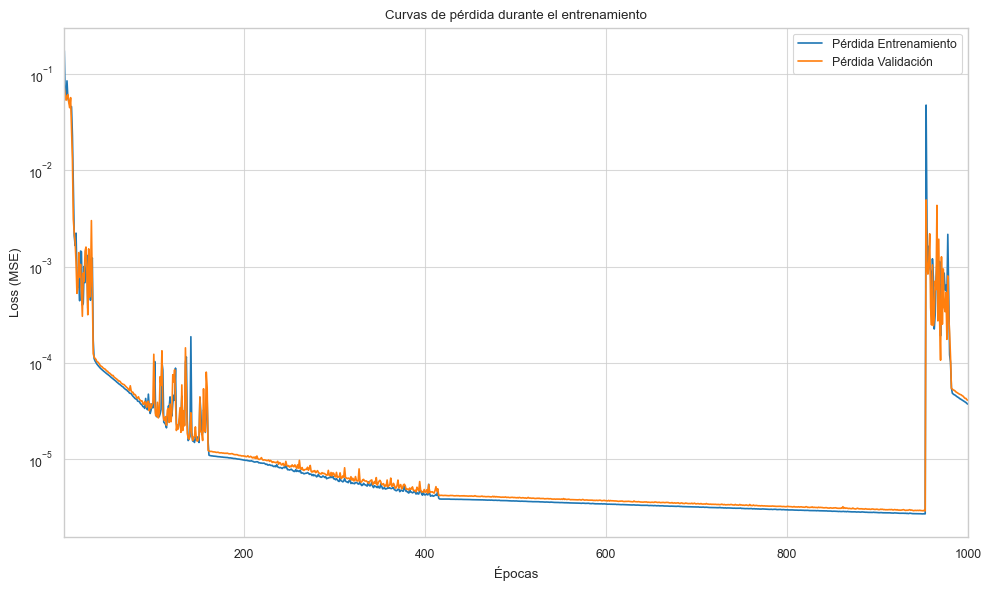

In [ ]:
plot_loss_curves(train_loss, test_loss)

### Evaluation

In [ ]:
# load the best model
model = PCB_ConvLSTM(input_channels=3, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

with torch.no_grad():
    y_pred = model(input_val)  # (B, T, 1, H, W)
    val_loss = criterion(y_pred, output_val)
    print(f"Test Loss: {val_loss.item():.6f}")

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_10336\703209444.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\ismael.gallo\\Desktop\\ia_thermal\\ismaelgallo\\models\\ConvLSTM\\PCB_ConvLSTM_nt1000_e1000_50s_lr0.001_bs16_h64-64_k3x3.pth'

### Analyzing results

In [ ]:
model = PCB_ConvLSTM(input_channels=3, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_10336\1680759677.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


RuntimeError: Error(s) in loading state_dict for PCB_ConvLSTM:
	Missing key(s) in state_dict: "convlstm.cell_list.0.conv.weight", "convlstm.cell_list.0.conv.bias", "convlstm.cell_list.1.conv.weight", "convlstm.cell_list.1.conv.bias", "decoder.weight", "decoder.bias". 
	Unexpected key(s) in state_dict: "encoder.encoder.0.weight", "encoder.encoder.0.bias", "encoder.encoder.2.weight", "encoder.encoder.2.bias", "encoder.encoder.4.weight", "encoder.encoder.4.bias", "encoder.encoder.8.weight", "encoder.encoder.8.bias", "temporal_fc.0.weight", "temporal_fc.0.bias", "temporal_decoder.transformer.layers.0.self_attn.in_proj_weight", "temporal_decoder.transformer.layers.0.self_attn.in_proj_bias", "temporal_decoder.transformer.layers.0.self_attn.out_proj.weight", "temporal_decoder.transformer.layers.0.self_attn.out_proj.bias", "temporal_decoder.transformer.layers.0.linear1.weight", "temporal_decoder.transformer.layers.0.linear1.bias", "temporal_decoder.transformer.layers.0.linear2.weight", "temporal_decoder.transformer.layers.0.linear2.bias", "temporal_decoder.transformer.layers.0.norm1.weight", "temporal_decoder.transformer.layers.0.norm1.bias", "temporal_decoder.transformer.layers.0.norm2.weight", "temporal_decoder.transformer.layers.0.norm2.bias", "temporal_decoder.to_map.0.weight", "temporal_decoder.to_map.0.bias", "temporal_decoder.to_map.2.weight", "temporal_decoder.to_map.2.bias". 

We are going to plot the temperature evolution in the four nodes corresponding with the heaters

In [ ]:
id_heaters = [(6,3), (3,6), (9,3), (9,9)]
id_random = [(0,0), (4, 4), (6, 3)]

Boundary conditions

In [ ]:
Q_heaters = np.array([1.0, 1.0, 1.0, 1.0])
T_interfaces = np.array([250, 250, 250, 250])
T_env = 250

Actual values

In [ ]:
T, _, _, _ = PCB_case_2(solver = 'transient', display=False, time = time_sim, dt = dt, T_init = T_init, Q_heaters = Q_heaters, T_interfaces = T_interfaces, Tenv = T_env) # heaters in default position
# T, _, _, _ = PCB_case_2(solver = 'transient', display=False, time = time_sim, dt = 1, T_init = T_init, Q_heaters = Q_heaters, T_interfaces = T_interfaces, Tenv = T_env) # heaters in default position
T = T.reshape(T.shape[0], nodes_side, nodes_side) # reshaping the data grid-shape
# T = downsample_solver_output(T, dt)  # downsample to match ConvLSTM input shape


Predicted values

In [ ]:
input_tensor = dataset.create_input_from_values(Q_heaters, T_interfaces, T_env, sequence_length=sequence_length)

output = model(input_tensor)
output_denorm = dataset.denormalize_output(output)
T_pred = output_denorm[0,:,0,:,:].cpu().detach().numpy()

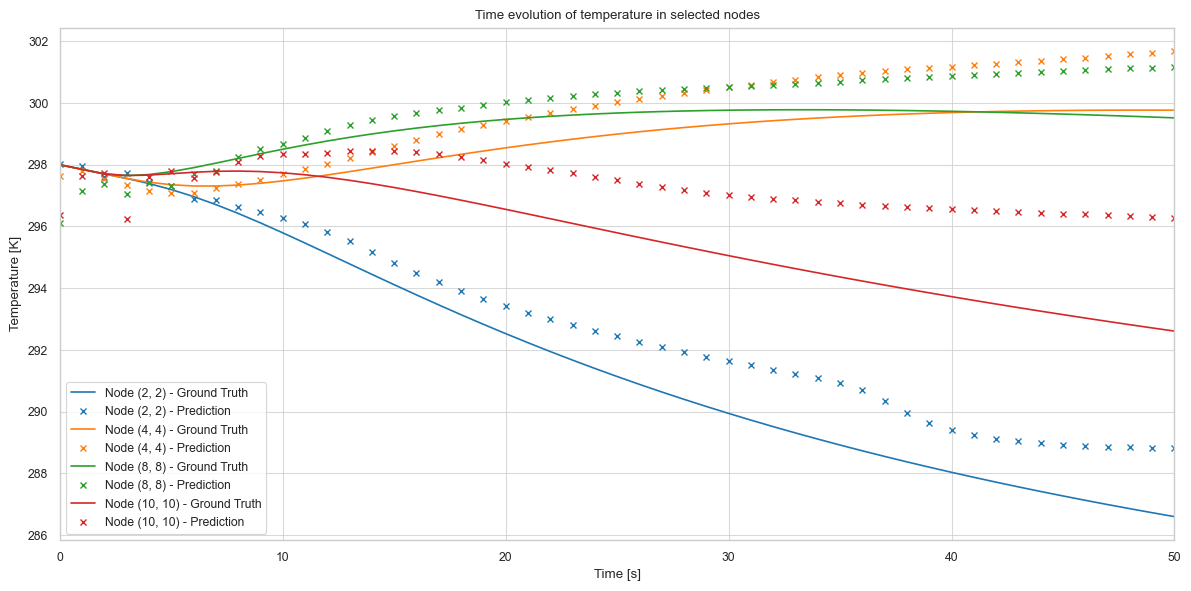

In [ ]:
plot_nodes_evolution(T_pred, T, id_random, together=True)

In [ ]:
np.random.seed(0)

Q_random = np.random.uniform(0.1, 1.25, 4)
T_interfaces_random = np.random.uniform(260, 310, 4)
T_env_random = np.random.uniform(260, 310)

input_tensor = dataset.create_input_from_values(Q_random, T_interfaces_random, T_env_random, sequence_length=sequence_length).to('cpu')

T_true = PCB_case_2(solver='transient', display=False, time=time_sim, dt=1, T_init=298.0, Q_heaters=Q_random, T_interfaces=T_interfaces_random, Tenv=T_env_random)[0]
T_true = T_true.reshape(T_true.shape[0], 13, 13) # reshaping the data grid-shape

model.to('cpu')
pred = model(input_tensor).detach()[0,:,0,:,:]
T_pred = dataset.denormalize_output(torch.tensor(pred)).numpy()

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_10336\1589751172.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T_pred = dataset.denormalize_output(torch.tensor(pred)).numpy()


Cálculo de porcentajes de acierto

In [ ]:
umbral = 6

acierto = porcentaje_error_bajo_umbral(T_true, T_pred, umbral=umbral)
print(f"Porcentaje de predicciones con error < {umbral:.1f} K: {acierto:.2f}%")

porcentaje, _, _ = nodos_siempre_dentro_umbral(T_true, T_pred, umbral=umbral)
print(f"Porcentaje de nodos buenos: {porcentaje:.2f}%")

Porcentaje de predicciones con error < 6.0 K: 92.56%
Porcentaje de nodos buenos: 86.98%


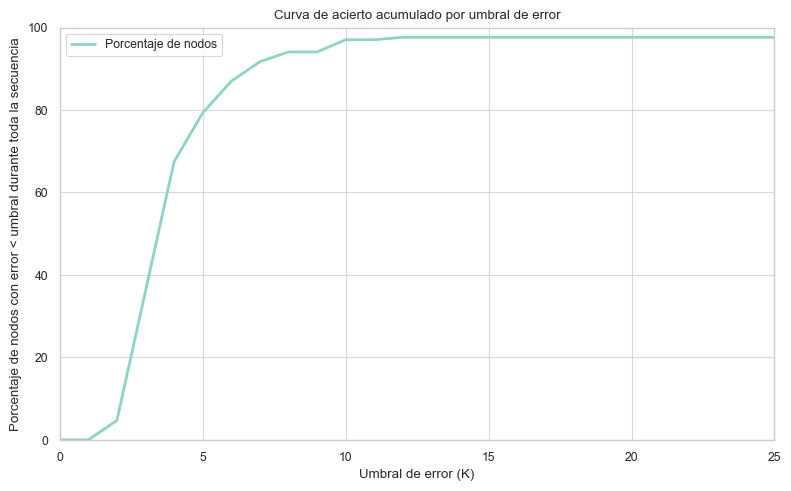

In [ ]:
umbrales = np.linspace(0, 25, 26)
porcentajes = porcentaje_nodos_siempre_dentro_por_umbral(T_true, T_pred, umbrales)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(umbrales, porcentajes, label="Porcentaje de nodos", linewidth=2)
plt.xlabel("Umbral de error (K)")
plt.ylabel("Porcentaje de nodos con error < umbral durante toda la secuencia")
plt.title("Curva de acierto acumulado por umbral de error")
plt.grid(True)
plt.ylim(0, 100)
plt.xlim(0, umbrales[-1])
plt.legend()
plt.tight_layout()
plt.show()

## Physics informed Convolutional LSTM

In [26]:
# from Physics_Loss import *

### New loss function validation

Validation of the Physics loss function

In [27]:
# Crear instancia de la clase de pérdida
physics_loss = PhysicsLossTransient().to(device)

# Parámetros
B = 1        # batch size
H = W = 13    # dimensiones espaciales

# Obtener datos reales del solver
T2, _, interfaces2, heaters2 = PCB_case_2(solver='transient', display=False, time=time_sim, dt=1, T_init=298.0)
T = T2.shape[0]      # número de pasos temporales

# Temperatura: [B, T, 1, 13, 13]
T_tensor = torch.tensor(T2, dtype=torch.float32).view(T, 1, H, W).unsqueeze(0).repeat(B, 1, 1, 1, 1).to(device)

interfaces_input = torch.tensor([list(interfaces2.values())], dtype=torch.float32).repeat(B, 1).to(device) # [B, 4]
heaters_input = torch.tensor([list(heaters2.values())], dtype=torch.float32).repeat(B, 1).to(device) # [B, 4]
Tenv = torch.full((B, 1), 250.0).to(device) # [B, 1]

# Calcular la pérdida
loss = physics_loss(
    T_pred=T_tensor,
    T_true=T_tensor,
    heaters_input=heaters_input,
    interfaces_input=interfaces_input,
    Tenv=Tenv
)

# # Mostrar resultado
print(f"Physics loss (esperada ≈ 0): {loss.item():.6e}")

Physics loss (esperada ≈ 0): 2.508949e-12


Validation of the boundary loss function

In [28]:
# Crear una instancia de BoundaryLoss con valores predeterminados
boundary_loss = BoundaryLoss()

# Ejemplo de tensores
interfaces_example = torch.tensor(list(interfaces2.values()), dtype=torch.float32).unsqueeze(0)
T2_reshaped = torch.tensor(T2).view(1, sequence_length, 1, 13, 13).to(device)  # [B, T, 1, H, W]

# Calcular la pérdida
loss = boundary_loss(T2_reshaped, interfaces_example)
print("Pérdida en las interfaces:", loss.item())

Pérdida en las interfaces: 0.0


Función para extraer las condiciones de contorno de los tensores de los 3 canales

### Model definition

Hyperparameters of training

In [29]:
mse_weight = 1.0
phy_weight = 0.1
bnd_weight = 0.001

In [30]:
# from convlstm import *

class PCB_ConvLSTM_physics(nn.Module):
    def __init__(self, input_channels=3, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13):
        super().__init__()
        self.convlstm = ConvLSTM(input_dim=input_channels,
                                 hidden_dim=hidden_dims,
                                 kernel_size=kernel_size,
                                 num_layers=len(hidden_dims),
                                 batch_first=True,
                                 bias=True,
                                 return_all_layers=False)

        self.decoder = nn.Conv2d(hidden_dims[-1], 1, kernel_size=1)

    def forward(self, x):
        # x: (B, T, C, H, W)
        lstm_out, _ = self.convlstm(x)  # lstm_out[0]: (B, T, hidden_dim, H, W)

        # Apply decoder to each time step
        decoded = [self.decoder(lstm_out[0][:, t]) for t in range(x.size(1))]
        output = torch.stack(decoded, dim=1)  # (B, T, 1, H, W)
        return output

Definición del modelo

In [31]:
dataset_train.base_dataset.return_bc = True
dataset_test.base_dataset.return_bc = True

train_ds = prepare_data_with_bc(dataset_train, device=device)
train_loader_phy = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

test_ds = prepare_data_with_bc(dataset_test, device=device)
test_loader_phy = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

model = PCB_ConvLSTM_physics(input_channels=3, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13).to(device)

total_loss_fn = TotalLoss(
    mse_weight=mse_weight,
    physics_weight=phy_weight,
    boundary_weight=bnd_weight,
    denormalize_output_fn=dataset.denormalize_output
)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lrdecay, patience=lrdecay_patience, verbose=True)

In [32]:
x0, y0, bc = next(iter(train_loader_phy))
print(x0.shape, y0.shape, bc.shape)

torch.Size([16, 51, 3, 13, 13]) torch.Size([16, 51, 1, 13, 13]) torch.Size([16, 9])


### Training

Training and saving best model with best parameters.

In [33]:
# Listas de pérdidas
train_loss, test_loss = [], []
loss_mse, loss_phy, loss_bndry = [], [], []

best_test_loss = np.inf
epochs_without_improvement = 0
elapsed_previous = 0.0  # minutos entrenados en sesiones previas

# Strings para nombre de archivo
kernel_string = f"{kernel_size[0][0]}x{kernel_size[0][1]}"
layer_string = f"{hidden_dims[0]}"
for d in hidden_dims[1:]:
    layer_string += f"-{d}"

# Directorio y paths
model_dir = os.path.join(dir_path, 'models', 'PINN')
if IN_COLAB:
    model_dir = os.path.join(MODELS_PATH, 'PINN')
os.makedirs(model_dir, exist_ok=True)

filename_phy = (
    f"PCB_PINN_nt{n_train}_e{epochs}_{time_sim}s_lr{lr}_bs{batch_size}"
    f"_h{layer_string}_k{kernel_string}_phy{phy_weight}_bnd{bnd_weight}.pth"
)
model_path_phy = os.path.join(model_dir, filename_phy)
json_path_phy  = model_path_phy.replace('.pth', '.json')

start_epoch = 0
start_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# --- Reanudación si existe checkpoint ---
if os.path.exists(model_path_phy):
    display(Markdown(f"🔁 Cargando PINN existente `{filename_phy}` y reanudando entrenamiento."))
    model.load_state_dict(torch.load(model_path_phy, map_location=device))

    if os.path.exists(json_path_phy):
        with open(json_path_phy, 'r') as f:
            prev = json.load(f)
        best_test_loss           = prev.get('best_test_loss', best_test_loss)
        train_loss               = prev.get('train_loss', [])
        test_loss                = prev.get('test_loss', [])
        loss_mse                 = prev.get('loss_mse', [])
        loss_phy                 = prev.get('loss_phy', [])
        loss_bndry               = prev.get('loss_bndry', [])
        elapsed_previous         = prev.get('training_duration_minutes', 0.0)
        start_datetime           = prev.get('start_datetime', start_datetime)
        start_epoch              = prev.get('epochs_trained', 0)
        epochs_without_improvement = 0
    else:
        display(Markdown("⚠️ No se encontró JSON previo; se reinicia contadores."))
else:
    display(Markdown(f"✨ Nuevo entrenamiento PINN: `{filename_phy}`"))

print("📁 Los resultados se guardarán en:", json_path_phy)

✨ Nuevo entrenamiento PINN: `PCB_PINN_nt1000_e1000_50s_lr0.01_bs16_h64-64_k3x3_phy0.1_bnd0.001.pth`

📁 Los resultados se guardarán en: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\models\PINN\PCB_PINN_nt1000_e1000_50s_lr0.01_bs16_h64-64_k3x3_phy0.1_bnd0.001.json


In [34]:
# Calculamos el tiempo de entrenamiento previo para offset
start_time_training = time.time() - (elapsed_previous * 60)

# --- Bucle desde start_epoch ---
for epoch in range(start_epoch, epochs):
    model.train()

    total_loss = 0.0
    total_loss_mse = 0.0
    total_loss_phy = 0.0
    total_loss_bndry = 0.0
    start_time_epoch = time.time()

    # Entrenamiento
    for x, y, bc_all in tqdm(train_loader_phy, desc=f"Epoch {epoch+1}/{epochs} - Training", leave=False):
        optimizer.zero_grad()

        q = bc_all[:, 0:4] # sin normalizar
        t_int = bc_all[:, 4:8] # sin normalizar
        t_env = bc_all[:, 8].unsqueeze(1) # sin normalizar

        q_denorm     = dataset.denormalize_Q_heaters(q)
        t_int_denorm = dataset.denormalize_T_interfaces(t_int)
        t_env_denorm = dataset.denormalize_T_env(t_env)
        y_denorm     = dataset.denormalize_output(y)

        y_hat = model(x) # model prediction
        y_hat_denorm = dataset.denormalize_output(y_hat)

        loss, loss_mse_batch, loss_phys_batch, loss_bdry_batch = total_loss_fn(y_hat, y, q_denorm, t_int_denorm, t_env_denorm)

        loss.backward()
        optimizer.step()
        total_loss += loss.detach().item()
        total_loss_mse += loss_mse_batch.item()
        total_loss_phy += loss_phys_batch.item()
        total_loss_bndry += loss_bdry_batch.item()

    epoch_train_loss = total_loss / len(train_loader_phy)
    epoch_loss_mse = total_loss_mse / len(train_loader_phy)
    epoch_loss_phy = total_loss_phy / len(train_loader_phy)
    epoch_loss_bndry = total_loss_bndry / len(train_loader_phy)

    train_loss.append(epoch_train_loss)
    loss_mse.append(epoch_loss_mse)
    loss_phy.append(epoch_loss_phy)
    loss_bndry.append(epoch_loss_bndry)

    # Validación
    model.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for x_test, y_test, bc_test in test_loader_phy:

            q = bc_test[:, 0:4]
            t_int = bc_test[:, 4:8]
            t_env = bc_test[:, 8].unsqueeze(1)

            q_denorm     = dataset.denormalize_Q_heaters(q)
            t_int_denorm = dataset.denormalize_T_interfaces(t_int)
            t_env_denorm = dataset.denormalize_T_env(t_env)
            y_denorm     = dataset.denormalize_output(y)
            y_hat_denorm = dataset.denormalize_output(y_hat)

            y_pred = model(x_test)

            test_loss_comb, _, _, _ = total_loss_fn(y_pred, y_test, q_denorm, t_int_denorm, t_env_denorm)
            total_test_loss += test_loss_comb.item()

    epoch_test_loss = total_test_loss / len(test_loader_phy)
    test_loss.append(epoch_test_loss)

    # Scheduler update
    scheduler.step(epoch_test_loss)

    elapsed_minutes = (time.time() - start_time_training) / 60

    # Early stopping check
    if epoch_test_loss < best_test_loss:
        best_test_loss = epoch_test_loss

        # Guardar el modelo
        torch.save(model.state_dict(), model_path_phy)

        current_lr = optimizer.param_groups[0]['lr']

        # Guardar hiperparámetros en JSON
        params = {
            'start_datetime': start_datetime,
            'training_duration_minutes': elapsed_minutes,
            "system_specs": system_specs,
            'hidden_dims': hidden_dims,
            'kernel_size': kernel_string,
            'batch_size': batch_size,
            'lr': lr,
            "scheduler":{
                "type": "ReduceLROnPlateau",
                "factor": lrdecay,
                "patience": lrdecay_patience,
                "final_lr": current_lr
            },
            'early_stop_patience': early_stop_patience,
            'epochs_trained': epoch + 1,
            'best_test_loss': best_test_loss,
            "train_loss": list(map(float, train_loss)),
            "test_loss": list(map(float, test_loss)),
            "physics": {
                "phy_param": phy_weight,
                "bnd_param": bnd_weight,
            }
        }

        with open(json_path_phy, 'w') as f:
            json.dump(params, f, indent=4)

        # print(f"✓ Saving model (epoch {epoch+1}) | test_loss improved to {best_test_loss:.6f}")
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        # print(f"No improvement for {epochs_without_improvement} epoch(s)")

    if epochs_without_improvement >= early_stop_patience:
        print(f"⚠️ Early stopping at epoch {epoch+1} — no improvement for {early_stop_patience} epochs.")
        break

    # Estadísticas finales de la época
    elapsed_epoch = time.time() - start_time_epoch
    # print(f"Epoch {epoch+1:3d} | Train Loss: {epoch_train_loss:.6f} | Test Loss: {epoch_test_loss:.6f} | Time: {elapsed_epoch:.2f}s")

print(f"Entrenamiento finalizado en {elapsed_minutes:.2f} minutos.")

Epoch 1/1000 - Training:   0%|          | 0/63 [00:00<?, ?it/s]

c:\Users\ismael.gallo\Desktop\ia_thermal\Physics_Loss.py:371: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


⚠️ Early stopping at epoch 149 — no improvement for 50 epochs.
Entrenamiento finalizado en 99.33 minutos.


Plotting validation loss and train loss

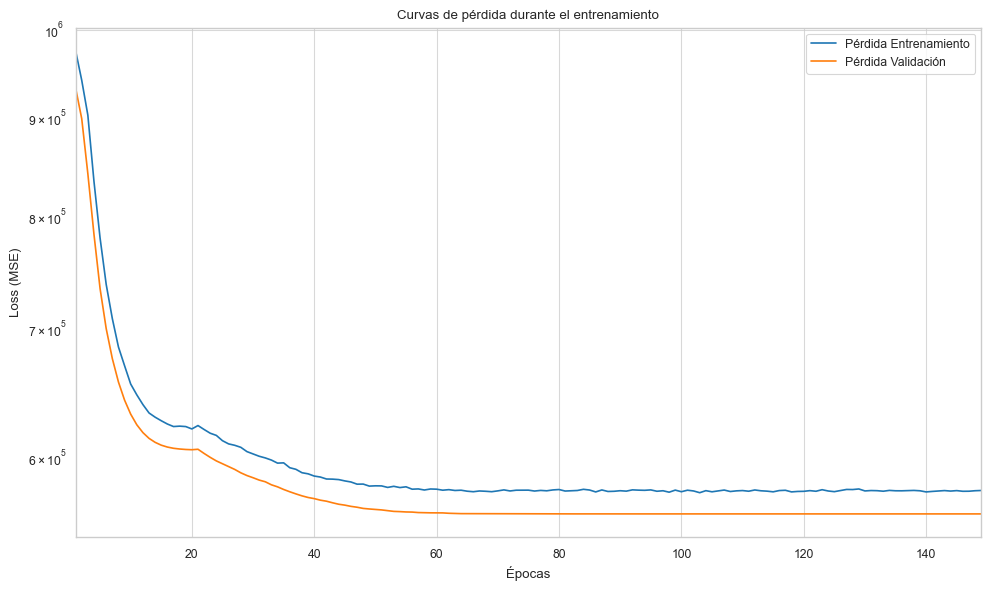

In [35]:
plot_loss_curves(train_loss, test_loss)

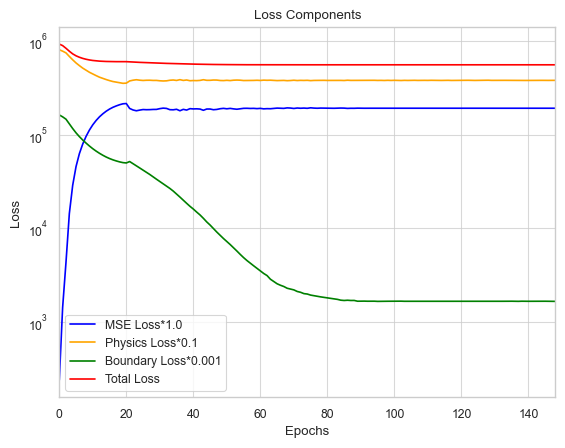

In [36]:
# Ensure loss_phy and loss_bndry are converted to NumPy arrays for element-wise multiplication
loss_mse = np.array(loss_mse)
loss_phy = np.array(loss_phy)
loss_bndry = np.array(loss_bndry)

plt.plot(loss_mse * mse_weight, label=f'MSE Loss*{mse_weight}', color='blue')
plt.plot(loss_phy * phy_weight, label=f'Physics Loss*{phy_weight}', color='orange')
plt.plot(loss_bndry * bnd_weight, label=f'Boundary Loss*{bnd_weight}', color='green')
plt.plot(test_loss, label='Total Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0, len(train_loss)-1)
plt.yscale('log')
plt.legend()
plt.title('Loss Components')
plt.show()


### Evaluation

In [37]:
# load the best model
model = PCB_ConvLSTM_physics(input_channels=3, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13).to(device)
model.load_state_dict(torch.load(model_path_phy))
model.eval()

criterion = nn.MSELoss() # para comparar colo con la recostrucción

with torch.no_grad():
    y_pred = model(input_val)  # (B, T, 1, H, W)
    val_loss = criterion(y_pred, output_val)
    print(f"Test Loss: {val_loss.item():.6f}")

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_10336\1489556165.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path_phy))


Test Loss: 192841.828125


### Analyzing results

In [38]:
model = PCB_ConvLSTM_physics(input_channels=3, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13).to(device)
model.load_state_dict(torch.load(model_path_phy))
model.eval()

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_10336\2622681878.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path_phy))


PCB_ConvLSTM_physics(
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(67, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (decoder): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)

We are going to plot the temperature evolution in the four nodes corresponding with the heaters

In [39]:
id_heaters = [(6,3), (3,6), (9,3), (9,9)]
id_random = [(2,2), (4,4), (8,8), (10,10)]

Boundary conditions

In [40]:
Q_heaters = np.array([1.0, 1.0, 1.0, 1.0])
T_interfaces = np.array([250, 250, 250, 250])
T_env = 250

Actual values

In [41]:
T, _, _, _ = PCB_case_2(solver = 'transient', display=False, time = time_sim, dt = dt, T_init = T_init, Q_heaters = Q_heaters, T_interfaces = T_interfaces, Tenv = T_env) # heaters in default position
T = T.reshape(T.shape[0], nodes_side, nodes_side) # reshaping the data grid-shape

Predicted values

In [42]:
input_tensor = dataset.create_input_from_values(Q_heaters, T_interfaces, T_env, sequence_length=sequence_length)

output = model(input_tensor)
output_denorm = dataset.denormalize_output(output)
T_pred = output_denorm[0,:,0,:,:].cpu().detach().numpy()

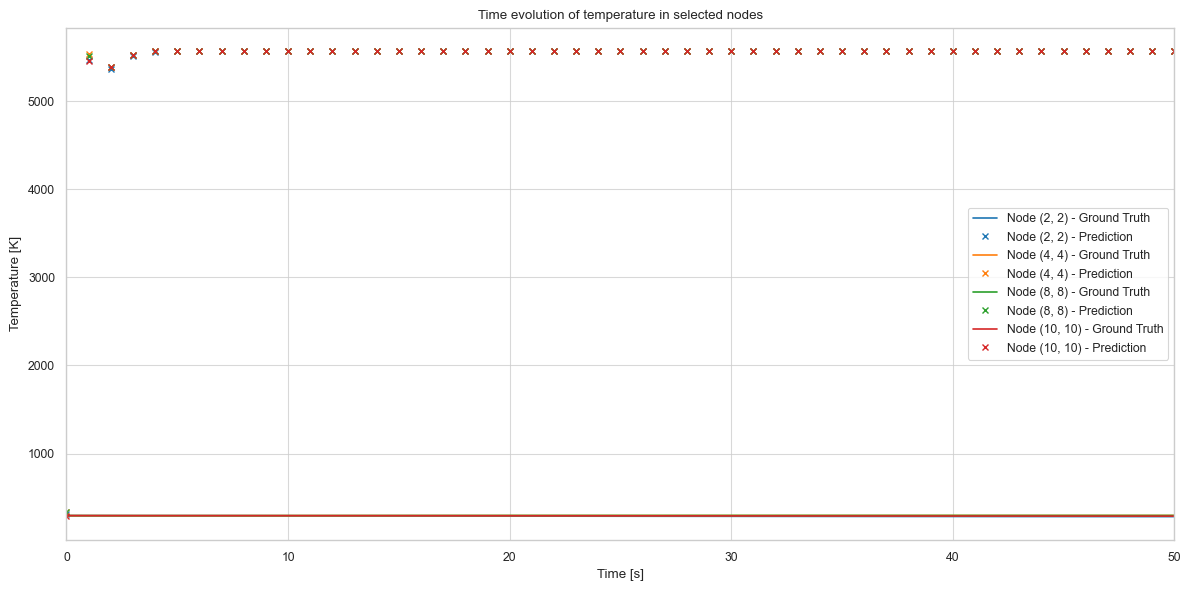

In [43]:
plot_nodes_evolution(T_pred, T, id_random, together=True)

In [46]:
np.random.seed(0)

Q_random = np.random.uniform(0.1, 1.25, 4)
T_interfaces_random = np.random.uniform(260, 310, 4)
T_env_random = np.random.uniform(260, 310)

input_tensor = dataset.create_input_from_values(Q_random, T_interfaces_random, T_env_random, sequence_length=sequence_length).to('cpu')

T_true = PCB_case_2(solver='transient', display=False, time=time_sim, dt=1, T_init=298.0, Q_heaters=Q_random, T_interfaces=T_interfaces_random, Tenv=T_env_random)[0]
T_true = T_true.reshape(T_true.shape[0], 13, 13) # reshaping the data grid-shape

model.to('cpu')
pred = model(input_tensor).detach()[0,:,0,:,:]
T_pred = dataset.denormalize_output(torch.tensor(pred)).numpy()

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_10336\1589751172.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T_pred = dataset.denormalize_output(torch.tensor(pred)).numpy()


Cálculo de porcentajes de acierto

In [47]:
umbral = 5

acierto = porcentaje_error_bajo_umbral(T_true, T_pred, umbral=umbral)
print(f"Porcentaje de predicciones con error < {umbral:.1f} K: {acierto:.2f}%")

porcentaje, _, _ = nodos_siempre_dentro_umbral(T_true, T_pred, umbral=umbral)
print(f"Porcentaje de nodos buenos: {porcentaje:.2f}%")

Porcentaje de predicciones con error < 5.0 K: 0.01%
Porcentaje de nodos buenos: 0.00%


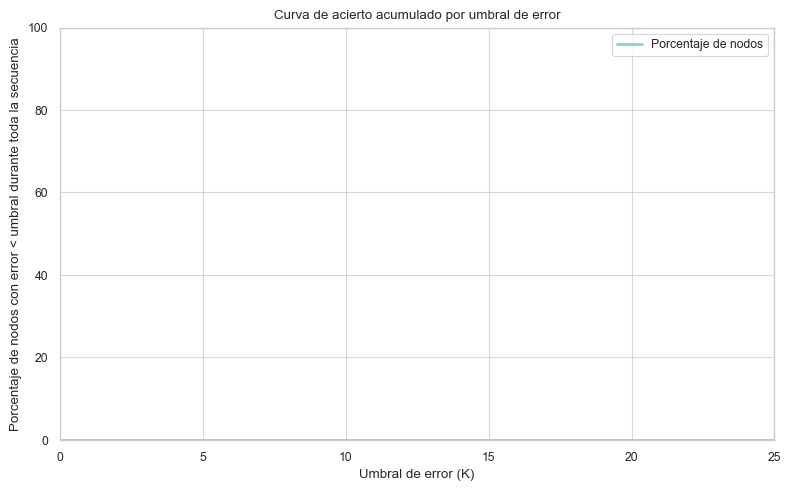

In [48]:
umbrales = np.linspace(0, 25, 26)
porcentajes = porcentaje_nodos_siempre_dentro_por_umbral(T_true, T_pred, umbrales)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(umbrales, porcentajes, label="Porcentaje de nodos", linewidth=2)
plt.xlabel("Umbral de error (K)")
plt.ylabel("Porcentaje de nodos con error < umbral durante toda la secuencia")
plt.title("Curva de acierto acumulado por umbral de error")
plt.grid(True)
plt.ylim(0, 100)
plt.xlim(0, umbrales[-1])
plt.legend()
plt.tight_layout()
plt.show()

Error en la predicción

In [49]:
plot_se_map(T_pred, T, time=100, show_pred=True)

IndexError: index 100 is out of bounds for axis 0 with size 51

Error en la predicción

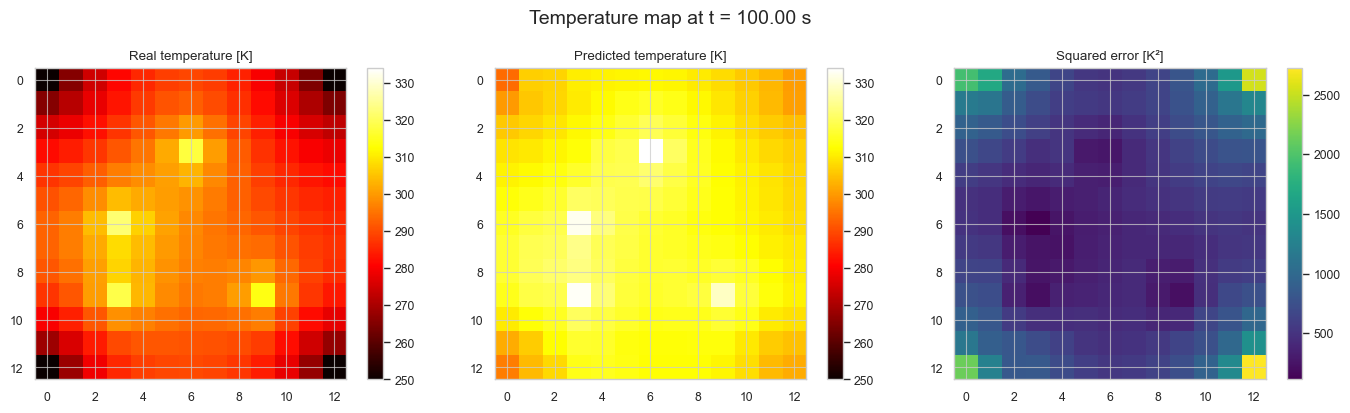

MSE: 636.55494300 K^2


In [ ]:
plot_se_map(T_pred, T, time=100, show_pred=True)

## Comparison of models

Loading models

In [ ]:
model = PCB_ConvLSTM(input_channels=3, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13).to(device)
model_phy = PCB_ConvLSTM_physics(input_channels=3, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13).to(device)

model.load_state_dict(torch.load(model_path))
model.to(device).eval()
model_phy.load_state_dict(torch.load(model_path_phy))
model_phy.to(device).eval()
print(f"Modelos cargados en dispositivo {device} y listos para evaluar.")

Modelos cargados en dispositivo cuda y listos para evaluar.


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_4312\496834614.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\

Generating random data to evaluate the models

In [ ]:
np.random.seed(0)

Q_random = np.random.uniform(0.1, 1.25, 4)
T_interfaces_random = np.random.uniform(260, 310, 4)
T_env_random = np.random.uniform(260, 310)

input_tensor = dataset.create_input_from_values(Q_random, T_interfaces_random, T_env_random, sequence_length=sequence_length)

T_true = PCB_case_2(solver='transient', display=False, time=100, dt=1, T_init=298.0, Q_heaters=Q_random, T_interfaces=T_interfaces_random, Tenv=T_env_random)[0]
T_true = T_true.reshape(T_true.shape[0], nodes_side, nodes_side) # reshaping the data grid-shape

pred = model(input_tensor).cpu().detach()[0,:,0,:,:]
T_pred = dataset.denormalize_output(torch.tensor(pred)).numpy()

pred_phy = model_phy(input_tensor).cpu().detach()[0,:,0,:,:]
T_pred_phy = dataset.denormalize_output(torch.tensor(pred_phy)).numpy()

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_4312\788729103.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T_pred = dataset.denormalize_output(torch.tensor(pred)).numpy()
C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_4312\788729103.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T_pred_phy = dataset.denormalize_output(torch.tensor(pred_phy)).numpy()


Error calculation

In [ ]:
error = T_true - T_pred
error_phy = T_true - T_pred_phy

error_last = error[-1]
error_phy_last = error_phy[-1]

Non-PINN

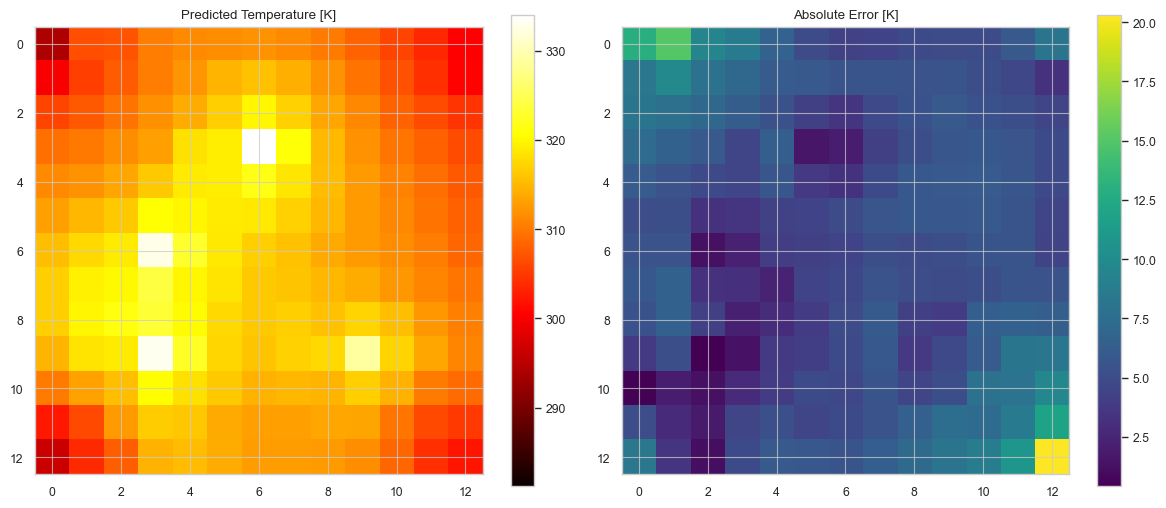

In [ ]:
plot_prediction_and_error(T_pred, T_true, t=100, cmap='hot', save_as_pdf=False, filename='prediction_and_error')

PINN

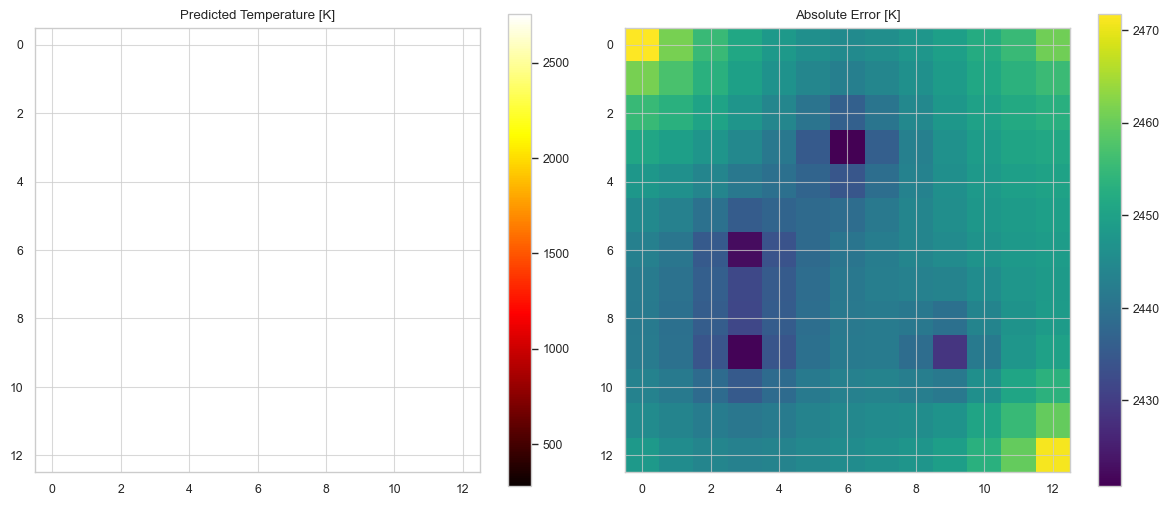

In [ ]:
plot_prediction_and_error(T_pred_phy, T_true, t=-1, cmap='hot', save_as_pdf=False, filename='prediction_and_error')

Error plot comparison

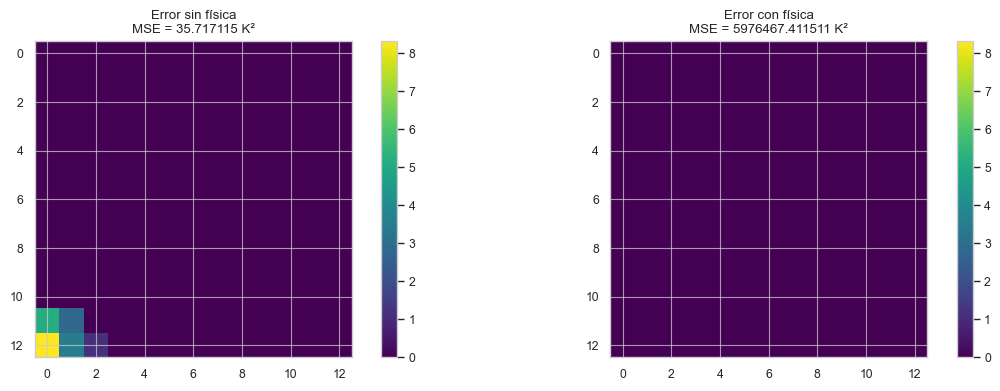

In [ ]:
compare_error_maps_2d(error_last, error_phy_last, ("Error sin física", "Error con física"), save_as_pdf=True)

# CNN Encoder (Conditional Spatio-Temporal Decoder)

Asistencia espectacular del chati aquí

## Common to all

In [50]:
from architectures.generic_spatiotemporal_decoder import GenericSpatioTemporalDecoder

### Hyperparameters of training

In [ ]:
# epochs = 1000
# lr = 1e-4
# lrdecay = 0.1
# lrdecay_patience = 10
# early_stop_patience = 50

embedding_dim = 512
num_layers = 4
nhead = 8
use_temporal_channel = True

## Non-physics CNN Encoder

### Model definition

In [111]:
model = GenericSpatioTemporalDecoder(
    embedding_dim=embedding_dim,
    num_layers=num_layers,
    nhead=nhead,
    use_temporal_channel=use_temporal_channel,
).to(device)
# model = GenericSpatioTemporalRegressor().to(device)


### Training

In [72]:
# criterion = nn.MSELoss()  # Puedes cambiar por PhysicsLossTransient si lo deseas
criterion = nn.SmoothL1Loss(beta=1.0) # Pérdida Huber
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lrdecay, patience=lrdecay_patience, verbose=True)

In [73]:
train_loss, test_loss = [], []
best_test_loss = np.inf
epochs_without_improvement = 0

dir_path = os.getcwd()
IN_COLAB = 'google.colab' in str(get_ipython())

model_dir = os.path.join(dir_path, 'models', 'TransformerDecoder')
if IN_COLAB:
    model_dir = "/content/models/TransformerDecoder"
os.makedirs(model_dir, exist_ok=True)

filename = f"PCB_Transformer_nt{n_train}_e{epochs}_{time_sim}s_lr{lr}_bs{batch_size}_emb{embedding_dim}_lay{num_layers}_nhead{nhead}.pth"
model_path = os.path.join(model_dir, filename)
json_path = model_path.replace('.pth', '.json')

if os.path.exists(model_path):
    print(f"🔁 Cargando modelo desde {model_path}")
    model.load_state_dict(torch.load(model_path, map_location=device))

    if os.path.exists(json_path):
        with open(json_path, "r") as f:
            previous = json.load(f)
        
        best_test_loss = previous.get("best_test_loss", np.inf)
        train_loss = previous.get("train_loss", [])
        test_loss = previous.get("test_loss", [])
        epochs_without_improvement = 0  # siempre se reinicia al mejorar

        # Recuperar valores de tiempo acumulado
        elapsed_previous = previous.get("training_duration_minutes", 0.0)
        start_datetime = previous.get("start_datetime", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    else:
        elapsed_previous = 0.0
        start_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
else:
    elapsed_previous = 0.0
    start_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

print("📁 El modelo se está guardando en:", json_path)

📁 El modelo se está guardando en: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\models\TransformerDecoder\PCB_Transformer_nt1000_e1000_50s_lr0.0001_bs16_emb512_lay4_nhead8.json


In [74]:
start_time_training = time.time()
# start_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

for epoch in range(len(train_loss), epochs):
    start_time_epoch = time.time()
    
    train_loss_epoch = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, epochs)
    test_loss_epoch = evaluate(model, test_loader, criterion, device)
    scheduler.step(test_loss_epoch)

    train_loss.append(train_loss_epoch)
    test_loss.append(test_loss_epoch)

    improved = test_loss_epoch < best_test_loss
    if improved:
        best_test_loss = test_loss_epoch
        torch.save(model.state_dict(), model_path)

        elapsed_minutes = elapsed_previous + (time.time() - start_time_training) / 60
        current_lr = optimizer.param_groups[0]["lr"]
        # Guardar hiperparámetros en JSON
        params = {
            'start_datetime': start_datetime,
            'training_duration_minutes': elapsed_minutes,
            "system_specs": system_specs,
            'batch_size': batch_size,
            "embedding_dim": embedding_dim,
            "num_layers": num_layers,
            "nhead": nhead,
            'lr': lr,
            "scheduler":{
                "type": "ReduceLROnPlateau",
                "factor": lrdecay,
                "patience": lrdecay_patience,
                "final_lr": current_lr
            },
            'early_stop_patience': early_stop_patience,
            'epochs_trained': epoch + 1,
            'best_test_loss': best_test_loss,
            "train_loss": list(map(float, train_loss)),
            "test_loss": list(map(float, test_loss)),
        }
        with open(json_path, "w") as f:
            json.dump(params, f, indent=4)
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stop_patience:
            print(f"⚠️ Early stopping en la época {epoch+1}.")
            break

    # print(f"Epoch {epoch+1:3d} | Train: {train_loss_epoch:.6f} | Test: {test_loss_epoch:.6f} | Time: {time.time() - start_time_epoch:.2f}s")
    
    if epochs_without_improvement >= early_stop_patience:
        print(f"⚠️ Early stopping en la época {epoch+1}.")
        break

print(f"Entrenamiento completo en {(time.time() - start_time_training)/60:.2f} minutos.")

⚠️ Early stopping en la época 249.
Entrenamiento completo en 625.73 minutos.


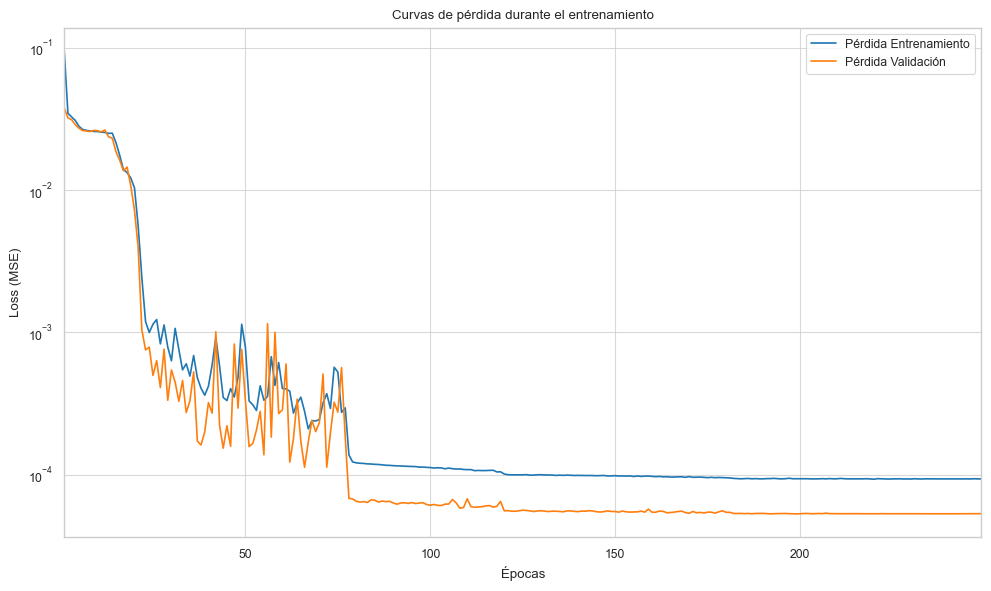

In [75]:
plot_loss_curves(train_loss, test_loss)

### Evaluation

In [112]:
model = GenericSpatioTemporalDecoder(
    embedding_dim=embedding_dim,
    num_layers=num_layers,
    nhead=nhead,
    use_temporal_channel=use_temporal_channel
).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

val_loss_value = evaluate(model, val_loader, criterion, device)
print(f"✅ Validation Loss del modelo guardado: {val_loss_value:.6f}")

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_10336\1543526428.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loca

RuntimeError: Error(s) in loading state_dict for GenericSpatioTemporalDecoder:
	Unexpected key(s) in state_dict: "temporal_fc.0.weight", "temporal_fc.0.bias". 
	size mismatch for encoder.encoder.0.weight: copying a param with shape torch.Size([64, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 4, 3, 3]).
	size mismatch for temporal_decoder.transformer.layers.0.self_attn.in_proj_weight: copying a param with shape torch.Size([768, 256]) from checkpoint, the shape in current model is torch.Size([384, 128]).
	size mismatch for temporal_decoder.transformer.layers.0.self_attn.in_proj_bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for temporal_decoder.transformer.layers.0.self_attn.out_proj.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for temporal_decoder.transformer.layers.0.self_attn.out_proj.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for temporal_decoder.transformer.layers.0.linear1.weight: copying a param with shape torch.Size([640, 256]) from checkpoint, the shape in current model is torch.Size([512, 128]).
	size mismatch for temporal_decoder.transformer.layers.0.linear1.bias: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for temporal_decoder.transformer.layers.0.linear2.weight: copying a param with shape torch.Size([256, 640]) from checkpoint, the shape in current model is torch.Size([128, 512]).
	size mismatch for temporal_decoder.transformer.layers.0.linear2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for temporal_decoder.transformer.layers.0.norm1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for temporal_decoder.transformer.layers.0.norm1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for temporal_decoder.transformer.layers.0.norm2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for temporal_decoder.transformer.layers.0.norm2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for temporal_decoder.to_map.0.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for temporal_decoder.to_map.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for temporal_decoder.to_map.2.weight: copying a param with shape torch.Size([169, 256]) from checkpoint, the shape in current model is torch.Size([169, 128]).

### Analyzing results

#### Nodes plot

In [113]:
# id_heaters = [(6,3), (3,6), (9,3), (9,9)]
id_random = [(0, 0), (4, 4), (6, 3)]

Boundary conditions

In [114]:
Q_heaters = np.array([1.0, 1.0, 1.0, 1.0])
T_interfaces = np.array([250, 250, 250, 250])
T_env = 250

Actual values

In [115]:
T, _, _, _ = PCB_case_2(solver = 'transient', display=False, time = time_sim, dt = dt, T_init = T_init, Q_heaters = Q_heaters, T_interfaces = T_interfaces, Tenv = T_env) # heaters in default position
T = T.reshape(T.shape[0], nodes_side, nodes_side) # reshaping the data grid-shape

Predicted values

In [116]:
input_tensor = dataset.create_input_from_values(Q_heaters, T_interfaces, T_env, sequence_length=sequence_length)

output = model(input_tensor)
output_denorm = dataset.denormalize_output(output)
T_pred = output_denorm[0,:,0,:,:].cpu().detach().numpy()

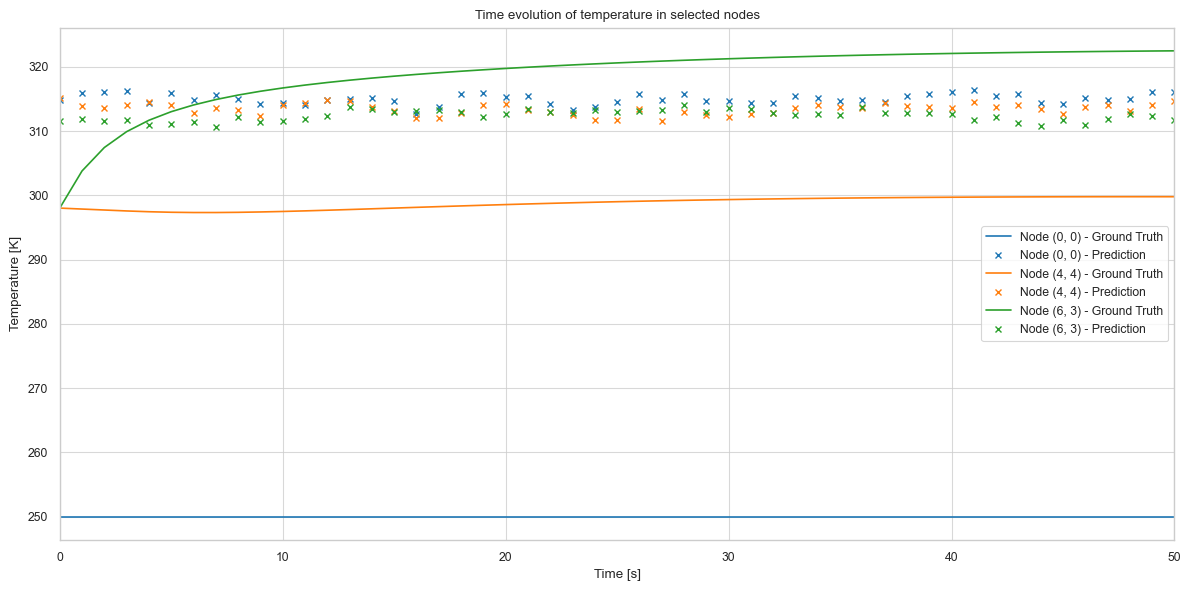

In [117]:
plot_nodes_evolution(T_pred, T, id_random, together=True)

#### Umbral de error

In [118]:
np.random.seed(0)

Q_random = np.random.uniform(0.1, 1.25, 4)
T_interfaces_random = np.random.uniform(260, 310, 4)
T_env_random = np.random.uniform(260, 310)

input_tensor = dataset.create_input_from_values(Q_random, T_interfaces_random, T_env_random, sequence_length=sequence_length).to('cpu')

T_true = T
T_true = T_true.reshape(T_true.shape[0], 13, 13) # reshaping the data grid-shape

model.to('cpu')
pred = model(input_tensor).detach()[0,:,0,:,:]
T_pred = dataset.denormalize_output(torch.tensor(pred)).numpy()

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_10336\947926529.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T_pred = dataset.denormalize_output(torch.tensor(pred)).numpy()


Cálculo de porcentajes de acierto

In [119]:
umbral = 5

acierto = porcentaje_error_bajo_umbral(T_true, T_pred, umbral=umbral)
print(f"Porcentaje de predicciones con error < {umbral:.1f} K: {acierto:.2f}%")

porcentaje, _, _ = nodos_siempre_dentro_umbral(T_true, T_pred, umbral=umbral)
print(f"Porcentaje de nodos buenos: {porcentaje:.2f}%")

Porcentaje de predicciones con error < 5.0 K: 1.69%
Porcentaje de nodos buenos: 0.00%


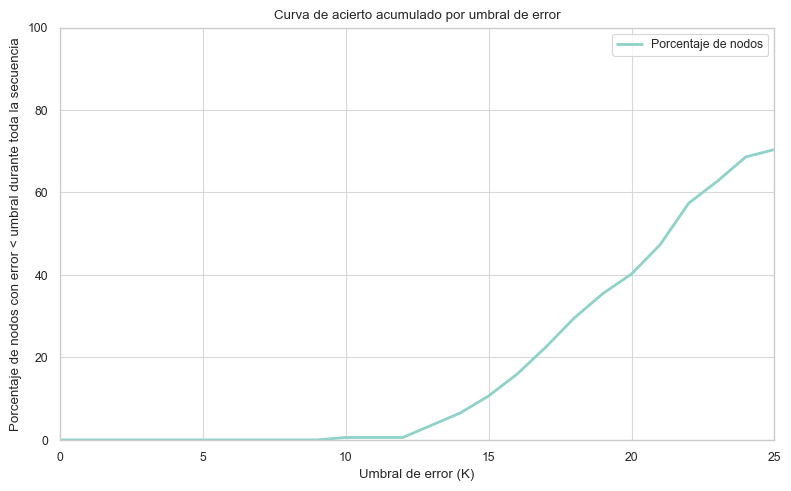

In [120]:
umbrales = np.linspace(0, 25, 26)
porcentajes = porcentaje_nodos_siempre_dentro_por_umbral(T_true, T_pred, umbrales)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(umbrales, porcentajes, label="Porcentaje de nodos", linewidth=2)
plt.xlabel("Umbral de error (K)")
plt.ylabel("Porcentaje de nodos con error < umbral durante toda la secuencia")
plt.title("Curva de acierto acumulado por umbral de error")
plt.grid(True)
plt.ylim(0, 100)
plt.xlim(0, umbrales[-1])
plt.legend()
plt.tight_layout()
plt.show()

#### Erorr por frame

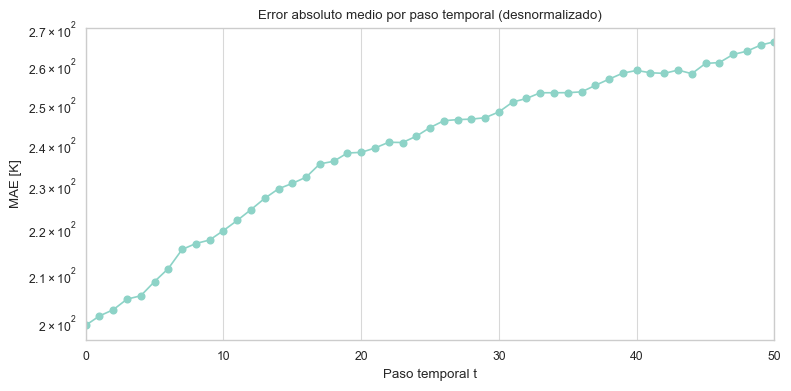

In [121]:
plot_mae_per_frame(T_true, T_pred, dataset)

#### Error por pixel

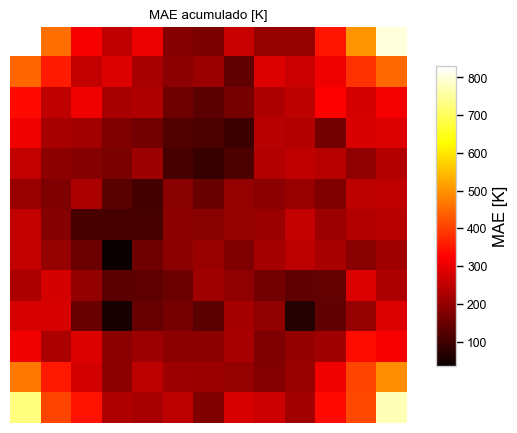

In [122]:
plot_mae_per_pixel(T_true, T_pred, dataset)

# CNN Regressor

## Common to all

In [89]:
from architectures.generic_spatiotemporal_regressor import GenericSpatioTemporalRegressor
from architectures.generic_spatiotemporal_decoder import *

In [90]:
epochs = 1000
lr = 1e-3
lrdecay = 0.5
lrdecay_patience = 10
early_stop_patience = 50

embedding_dim = 128
num_layers = 1
nhead = 4
weigth_decay = 1e-4
dim_ff_factor = 5
dim_ff = dim_ff_factor * embedding_dim 
param_dropout = 0.2

We need to adapt the dataloader because time has to appear as a parameter.

In [91]:
train_dataset_reg = TemporalRegressionDataset(input_train, output_train)
test_dataset_reg = TemporalRegressionDataset(input_test, output_test)
val_dataset_reg = TemporalRegressionDataset(input_val, output_val)

train_loader_reg = DataLoader(train_dataset_reg, batch_size=batch_size, shuffle=True)
test_loader_reg = DataLoader(test_dataset_reg, batch_size=batch_size, shuffle=False)
val_loader_reg = DataLoader(val_dataset_reg, batch_size=batch_size, shuffle=False)

## Non-physics regressor

### Custom Transformer Decoder

In [92]:
class CustomTransformerDecoder(TransformerDecoder):
    def __init__(self, embedding_dim, num_layers, nhead, dim_ff, dropout):
        super().__init__(embedding_dim, num_layers, nhead)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)


### Model definition

In [93]:
# Instanciar el modelo
model = GenericSpatioTemporalRegressor(
    embedding_dim=embedding_dim,
    num_layers=num_layers,
    nhead=nhead
).to(device)

model.temporal_decoder = CustomTransformerDecoder(
    embedding_dim=embedding_dim * 2, # lo hace así optuna
    num_layers=num_layers,
    nhead=nhead,
    dim_ff=dim_ff,
    dropout=param_dropout
).to(device)

### Training

In [94]:
criterion = nn.MSELoss()  # Puedes cambiar por PhysicsLossTransient si lo deseas
# criterion = nn.SmoothL1Loss(beta=1.0) # Pérdida Huber
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weigth_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lrdecay, patience=lrdecay_patience, verbose=True)

In [95]:
train_loss, test_loss = [], []
best_test_loss = np.inf
epochs_without_improvement = 0

dir_path = os.getcwd()
IN_COLAB = 'google.colab' in str(get_ipython())

model_dir = os.path.join(dir_path, 'models', 'TransformerRegressor')
if IN_COLAB:
    model_dir = "/content/models/TransformerRegressor"
os.makedirs(model_dir, exist_ok=True)

filename = f"PCB_TransformerRegressor_nt{n_train}_e{epochs}_{time_sim}s_lr{lr}_bs{batch_size}_emb{embedding_dim}_lay{num_layers}_nhead{nhead}.pth"
model_path = os.path.join(model_dir, filename)
json_path = model_path.replace('.pth', '.json')

if os.path.exists(model_path):
    print(f"🔁 Cargando modelo desde {model_path}")
    model.load_state_dict(torch.load(model_path, map_location=device))

    if os.path.exists(json_path):
        with open(json_path, "r") as f:
            previous = json.load(f)
        
        best_test_loss = previous.get("best_test_loss", np.inf)
        train_loss = previous.get("train_loss", [])
        test_loss = previous.get("test_loss", [])
        epochs_without_improvement = 0  # siempre se reinicia al mejorar

        # Recuperar valores de tiempo acumulado
        elapsed_previous = previous.get("training_duration_minutes", 0.0)
        start_datetime = previous.get("start_datetime", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    else:
        elapsed_previous = 0.0
        start_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
else:
    elapsed_previous = 0.0
    start_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

print("📁 El modelo se está guardando en:", json_path)

🔁 Cargando modelo desde c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\models\TransformerRegressor\PCB_TransformerRegressor_nt1000_e1000_50s_lr0.001_bs16_emb128_lay1_nhead4.pth
📁 El modelo se está guardando en: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\models\TransformerRegressor\PCB_TransformerRegressor_nt1000_e1000_50s_lr0.001_bs16_emb128_lay1_nhead4.json


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_10336\317729107.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loca

In [96]:
start_time_training = time.time()
# start_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

for epoch in range(len(train_loss), epochs):
    start_time_epoch = time.time()

    train_loss_epoch = train_one_epoch(model, train_loader_reg, criterion, optimizer, device, epoch, epochs)
    test_loss_epoch = evaluate(model, test_loader_reg, criterion, device)
    scheduler.step(test_loss_epoch)

    train_loss.append(train_loss_epoch)
    test_loss.append(test_loss_epoch)

    improved = test_loss_epoch < best_test_loss
    if improved:
        best_test_loss = test_loss_epoch
        torch.save(model.state_dict(), model_path)

        elapsed_minutes = elapsed_previous + (time.time() - start_time_training) / 60
        current_lr = optimizer.param_groups[0]["lr"]
        # Guardar hiperparámetros en JSON
        params = {
            'start_datetime': start_datetime,
            'training_duration_minutes': elapsed_minutes,
            "system_specs": system_specs,
            'batch_size': batch_size,
            "embedding_dim": embedding_dim,
            "num_layers": num_layers,
            "nhead": nhead,
            'lr': lr,
            "scheduler":{
                "type": "ReduceLROnPlateau",
                "factor": lrdecay,
                "patience": lrdecay_patience,
                "final_lr": current_lr
            },
            'early_stop_patience': early_stop_patience,
            'epochs_trained': epoch + 1,
            'best_test_loss': best_test_loss,
            "train_loss": list(map(float, train_loss)),
            "test_loss": list(map(float, test_loss)),
        }
        with open(json_path, "w") as f:
            json.dump(params, f, indent=4)
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stop_patience:
            print(f"⚠️ Early stopping en la época {epoch+1}.")
            break

    # print(f"Epoch {epoch+1:3d} | Train: {train_loss_epoch:.6f} | Test: {test_loss_epoch:.6f} | Time: {time.time() - start_time_epoch:.2f}s")
    
    if epochs_without_improvement >= early_stop_patience:
        print(f"⚠️ Early stopping en la época {epoch+1}.")
        break

print(f"Entrenamiento completo en {(time.time() - start_time_training)/60:.2f} minutos.")

⚠️ Early stopping en la época 395.
Entrenamiento completo en 0.88 minutos.


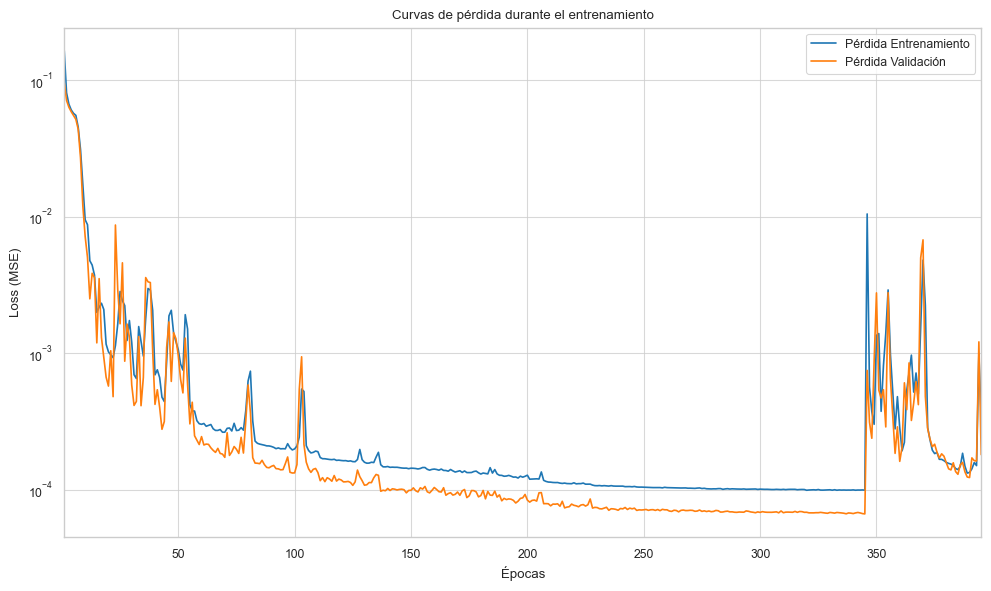

In [97]:
plot_loss_curves(train_loss, test_loss)

### Evaluation

In [98]:
# Instanciar el modelo
model = GenericSpatioTemporalRegressor(
    embedding_dim=embedding_dim,
    num_layers=num_layers,
    nhead=nhead
).to(device)

model.temporal_decoder = CustomTransformerDecoder(
    embedding_dim=embedding_dim * 2, # lo hace así optuna
    num_layers=num_layers,
    nhead=nhead,
    dim_ff=dim_ff,
    dropout=param_dropout
).to(device)

model.load_state_dict(torch.load(model_path, map_location=device))

model.eval()

val_loss_value = evaluate(model, val_loader_reg, criterion, device)
print(f"✅ Validation Loss del modelo guardado: {val_loss_value:.6f}")

✅ Validation Loss del modelo guardado: 0.000050


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_10336\1601976246.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loc

### Analyzing results

#### Nodes plot

In [99]:
id_heaters = [(6,3), (3,6), (9,3), (9,9)]
id_random = [(2,2), (4,4), (8,8), (10,10)]

Boundary conditions

In [100]:
Q_heaters = np.array([1.0, 1.0, 1.0, 1.0])
T_interfaces = np.array([250, 250, 250, 250])
T_env = 250

Actual values

In [101]:
T, _, _, _ = PCB_case_2(solver = 'transient', display=False, time = time_sim, dt = dt, T_init = T_init, Q_heaters = Q_heaters, T_interfaces = T_interfaces, Tenv = T_env) # heaters in default position
T = T.reshape(T.shape[0], nodes_side, nodes_side) # reshaping the data grid-shape

Predicted values

In [102]:
input_tensor = dataset.create_input_from_values(Q_heaters, T_interfaces, T_env, sequence_length=sequence_length)

# Crear t_seq normalizado: (1, T, 1)
t_seq = torch.linspace(0, 1, steps=sequence_length).view(1, sequence_length, 1).to(input_tensor.device)

output = model(input_tensor[:,0], t_seq)
output_denorm = dataset.denormalize_output(output)
T_pred = output_denorm[0,:,0,:,:].cpu().detach().numpy()

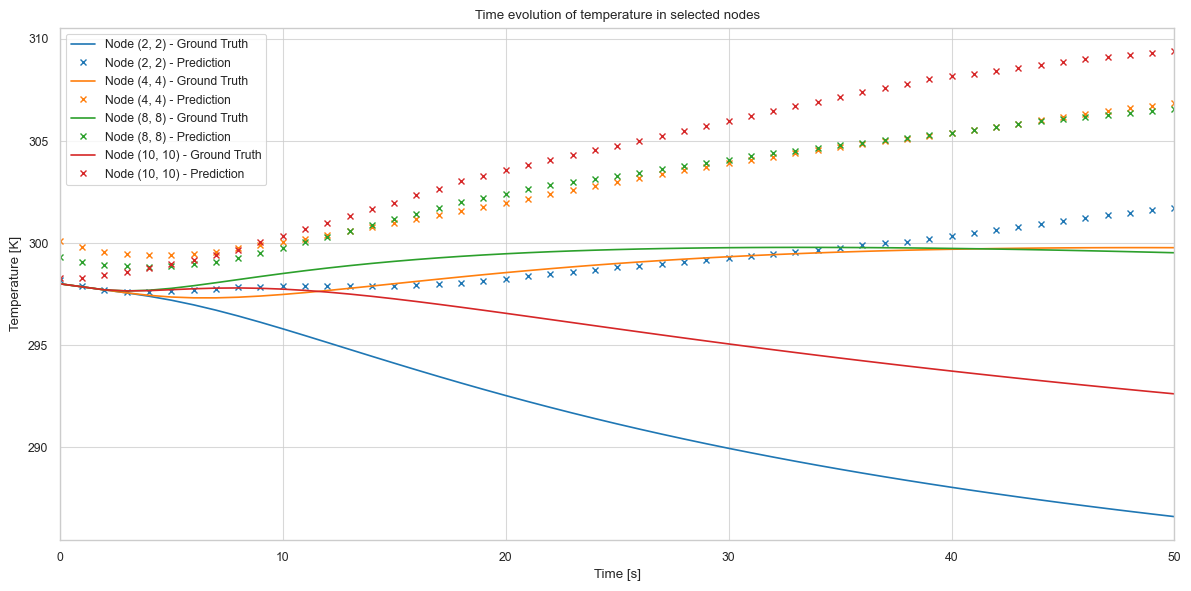

In [103]:
plot_nodes_evolution(T_pred, T, id_random, together=True)

#### Umbral de error

In [104]:
np.random.seed(0)

Q_random = np.random.uniform(0.1, 1.25, 4)
T_interfaces_random = np.random.uniform(260, 310, 4)
T_env_random = np.random.uniform(260, 310)

input_tensor = dataset.create_input_from_values(Q_random, T_interfaces_random, T_env_random, sequence_length=sequence_length).to(device)

T_true = T
T_true = T_true.reshape(T_true.shape[0], 13, 13) # reshaping the data grid-shape

# model.to('cpu')
pred = model(input_tensor[:,0], t_seq).detach()[0,:,0,:,:]
T_pred = dataset.denormalize_output(torch.tensor(pred)).cpu().numpy()

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_10336\3730587372.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T_pred = dataset.denormalize_output(torch.tensor(pred)).cpu().numpy()


Cálculo de porcentajes de acierto

In [105]:
umbral = 5

acierto = porcentaje_error_bajo_umbral(T_true, T_pred, umbral=umbral)
print(f"Porcentaje de predicciones con error < {umbral:.1f} K: {acierto:.2f}%")

porcentaje, _, _ = nodos_siempre_dentro_umbral(T_true, T_pred, umbral=umbral)
print(f"Porcentaje de nodos buenos: {porcentaje:.2f}%")

Porcentaje de predicciones con error < 5.0 K: 32.53%
Porcentaje de nodos buenos: 0.00%


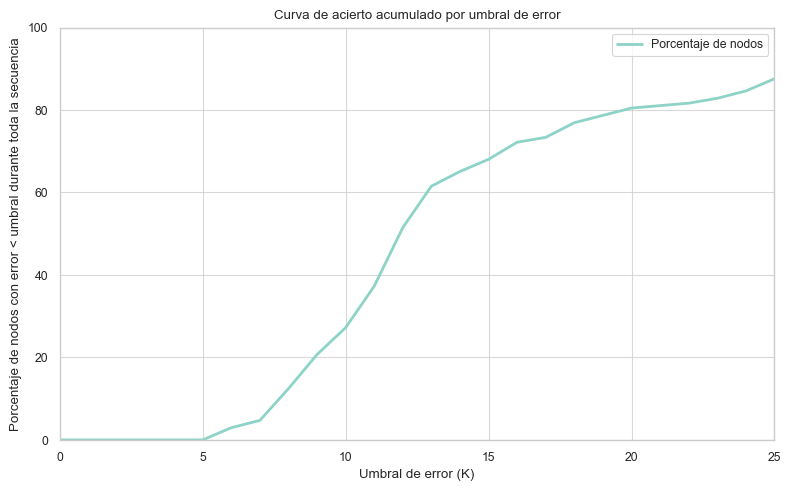

In [106]:
umbrales = np.linspace(0, 25, 26)
porcentajes = porcentaje_nodos_siempre_dentro_por_umbral(T_true, T_pred, umbrales)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(umbrales, porcentajes, label="Porcentaje de nodos", linewidth=2)
plt.xlabel("Umbral de error (K)")
plt.ylabel("Porcentaje de nodos con error < umbral durante toda la secuencia")
plt.title("Curva de acierto acumulado por umbral de error")
plt.grid(True)
plt.ylim(0, 100)
plt.xlim(0, umbrales[-1])
plt.legend()
plt.tight_layout()
plt.show()

#### Erorr por frame

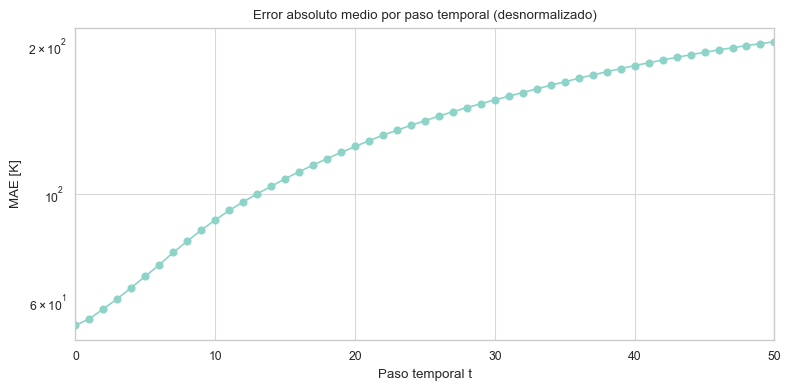

In [107]:
plot_mae_per_frame(T_true, T_pred, dataset)

#### Error por pixel

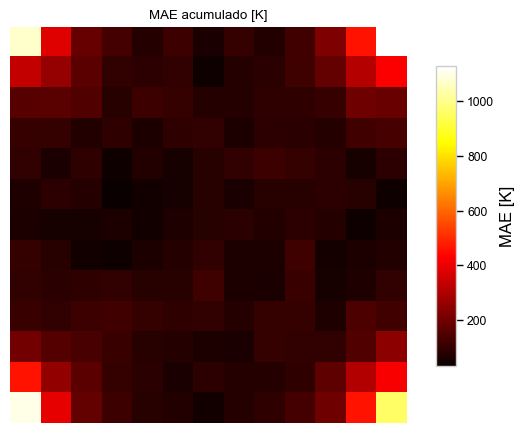

In [108]:
plot_mae_per_pixel(T_true, T_pred, dataset)